In [1]:
import numpy as np
import pandas as pd
import geojson
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
from shapely import geometry, ops
import rasterio
from rasterio import features
import geemap
import ee

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

In [2]:
arctic = gpd.read_file('../arctic_h90.shp').drop_duplicates(subset='HYBAS_ID', keep="first")
midlat = gpd.read_file('../midlat_h90.shp').drop_duplicates(subset='HYBAS_ID', keep="first")



In [3]:
joined = pd.concat([arctic, midlat]).drop_duplicates(subset='HYBAS_ID', keep="first")

joined = joined.set_crs("EPSG:4326").to_crs('EPSG:5936')

# Dumb, move this

joined['DD'] = joined['segment']/joined['flow_acc']


In [4]:
joined['HYBAS_ID'].value_counts().value_counts()

1    104089
Name: HYBAS_ID, dtype: int64

In [5]:
joined_unfiltered =  joined
joined = joined.loc[(joined['bio12_mean'] < 1000) & (joined['ndvi_mean'] > 6000)]

In [6]:
permaice = gpd.read_file('./shapefiles/permaice.shp')

LGM = gpd.read_file('./shapefiles/LGM_best_estimate.shp')
MIS6 = gpd.read_file('./shapefiles/MIS6_best_estimate.shp').explode()
LGM_dissolve = LGM.dissolve().to_crs('EPSG:5936')
MIS6_dissolve = MIS6.dissolve().to_crs('EPSG:5936')
LGM_dissolve['in_LGM'] = True
MIS6_dissolve['in_MIS6'] = True

joined = (
    gpd.sjoin(joined, LGM_dissolve[['geometry','in_LGM']], how="left", op="within")
    .drop(['index_right'], axis=1)
    )
joined = (
    gpd.sjoin(joined, MIS6_dissolve[['geometry','in_MIS6']], how="left", op="within")
    .drop(['index_right'], axis=1)
)

joined['glaciated'] = 'Not glaciated'

joined.loc[joined["in_MIS6"] == True, 'glaciated'] = 'MIS6'
joined.loc[joined["in_LGM"] == True, 'glaciated'] = 'LGM'

/scratch/ipykernel_39249/2166275371.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  MIS6 = gpd.read_file('./shapefiles/MIS6_best_estimate.shp').explode()
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
joined_pf = (
    gpd.sjoin(joined.to_crs('EPSG:5936'),permaice.to_crs('EPSG:5936'))
    .drop(['index_right'], axis=1)
)


In [8]:
joined_pf['EXTENT'] = joined_pf['EXTENT'].fillna("No permafrost")
joined_pf['EXTENT'] = joined_pf['EXTENT'].str.replace('C','Continuous')
joined_pf['EXTENT'] = joined_pf['EXTENT'].str.replace('D','Discontinuous')
joined_pf['EXTENT'] = joined_pf['EXTENT'].str.replace('I','Isolated')
joined_pf['EXTENT'] = joined_pf['EXTENT'].str.replace('S','Sporadic')

check that you are not double counting

In [9]:
joined_pf['HYBAS_ID'].value_counts()

8100022670    1
7100998830    1
7100310790    1
7100973070    1
7100341760    1
             ..
3100304620    1
3100311380    1
3100833160    1
3100302410    1
3100024210    1
Name: HYBAS_ID, Length: 69684, dtype: int64

In [10]:
permafrost = joined_pf.loc[joined_pf['EXTENT'] != 'No permafrost']
nonpermafrost = joined_pf.loc[joined_pf['EXTENT'] == 'No permafrost']

# Find sheds for flow routing

We need to find watersheds where we can get 10 m DEMs so either in the US or >60 degrees latitude for ArcticDEM.

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()
us = joined_pf.to_crs('epsg:4326').sjoin(world)
us = us.loc[us["name"]=="United States of America"]

In [12]:
highlat = joined_pf[joined_pf['lat']>60.0].to_crs('epsg:4326')
# .sjoin(world)

# # This is to not use alaska bc LSDTT bug with single digit UTM zones
# highlat = highlat.loc[highlat["name"]!="United States of America"]

In [13]:
sheds_10m = pd.concat([us, highlat]).drop_duplicates(subset='HYBAS_ID', keep="first")
sheds_10m = sheds_10m[sheds_10m['glaciated']=='Not glaciated']

In [14]:
sheds_10m['EXTENT'].value_counts()

Continuous       5938
No permafrost    2553
Discontinuous    1408
Isolated          721
Sporadic          396
Name: EXTENT, dtype: int64

In [15]:
def gen_random_sheds(df, pts, map_max, relief_max, n):
    map_array=np.append(np.linspace(-1,map_max,num=pts), [np.inf])
    relief_array=np.append(np.linspace(-1,relief_max,num=pts), [np.inf])

    df['bin_map_2'] = pd.cut(df['bio12_mean'],bins=map_array, labels=np.arange(len(map_array)-1),
                                )
    df['bin_relief_2'] = pd.cut(df['relief'],bins=relief_array, labels=np.arange(len(relief_array)-1),
                                )
    coarse_groups_out = df.groupby(['bin_map_2','bin_relief_2'])['DD']

    random_sheds = pd.DataFrame()

    for i, cut1 in enumerate(map_array[:-1]):
        for j, cut2 in enumerate(relief_array[:-1]):
            try:
                shed = df.loc[(df['bin_map_2'] == i) & (df['bin_relief_2'] == j)].sample(
                    n=n,
                    random_state=1
                )
            except ValueError:
                shed = pd.DataFrame({'bin_map_2': [i],
                                     'bin_relief_2': [j]
                                     })
            # random_sheds = random_sheds.append(shed)
            random_sheds = pd.concat([random_sheds,shed])

    return random_sheds


In [16]:
# random_ex = gen_random_sheds(sheds_10m[(sheds_10m['EXTENT']=="Continuous") | (sheds_10m['EXTENT']=="Discontinuous")], 5, 600, 1000, 16)

# random_pa = gen_random_sheds(sheds_10m[(sheds_10m['EXTENT']=="Isolated") | (sheds_10m['EXTENT']=="Sporadic")], 5, 600, 1000, 16)

random_cont = gen_random_sheds(sheds_10m[sheds_10m['EXTENT']=="Continuous"], 5, 600, 1000, 45)
random_np = gen_random_sheds(sheds_10m[sheds_10m['EXTENT']=="No permafrost"], 5, 600, 1000, 36)

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some

In [17]:
shed_list = pd.concat([random_cont.drop(index=0), random_np.drop(index=0)]).filter(['HYBAS_ID', 'DD', 'EXTENT'])

In [18]:
shed_list.dropna().drop_duplicates(subset='HYBAS_ID', keep="first").to_csv("shed_list_for_dd_new.csv", index=False)

# Plots

In [19]:
pts=20
map_max=800
relief_max=1200
map_array=np.append(np.linspace(-1,map_max,num=pts), [np.inf])
relief_array=np.append(np.linspace(-1,relief_max,num=pts), [np.inf])

nonpermafrost['bin_map'] = pd.cut(nonpermafrost['bio12_mean'],bins=map_array, labels=np.arange(len(map_array)-1))
nonpermafrost['bin_relief'] = pd.cut(nonpermafrost['relief'],bins=relief_array, labels=np.arange(len(relief_array)-1))
nonpermafrost_out = nonpermafrost.groupby(['bin_map','bin_relief'])['DD']

nonpermafrost_counts = nonpermafrost_out.count().sort_index().values.reshape(len(relief_array)-1,len(map_array)-1)

nonpermafrost_arr = nonpermafrost_out.mean().sort_index().values.reshape(len(relief_array)-1,len(map_array)-1)

permafrost['bin_map'] = pd.cut(permafrost['bio12_mean'],bins=map_array, labels=np.arange(len(map_array)-1),
                             )
permafrost['bin_relief'] = pd.cut(permafrost['relief'],bins=relief_array, labels=np.arange(len(relief_array)-1),
                              )
permafrost_out = permafrost.groupby(['bin_map','bin_relief'])['DD']

permafrost_counts = permafrost_out.count().sort_index().values.reshape(len(relief_array)-1,len(map_array)-1)

permafrost_arr = permafrost_out.mean().sort_index().values.reshape(len(relief_array)-1,len(map_array)-1)

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A

In [20]:
import scipy
import itertools
p = np.empty([pts,pts])
p[:] = np.nan
for i in itertools.product(range(pts),range(pts)):
    try:
        U1, p[i] = scipy.stats.mannwhitneyu(
        permafrost_out.get_group(i),
        nonpermafrost_out.get_group(i))
    except KeyError:
        pass

In [21]:
shed_count_thresh = 10

pm1 = np.ma.masked_less(p, 1.00e-04)
pm1_masked = np.ma.masked_where(permafrost_counts < shed_count_thresh, pm1)
pm1_masked = np.ma.masked_where(nonpermafrost_counts < shed_count_thresh, pm1_masked)


pm2 = np.ma.masked_inside(p, 1.00e-04, 1.00e-03)
pm2_masked = np.ma.masked_where(permafrost_counts < shed_count_thresh, pm2)
pm2_masked = np.ma.masked_where(nonpermafrost_counts < shed_count_thresh, pm2_masked)

ratio = permafrost_arr/nonpermafrost_arr
ratio_masked = np.ma.masked_where(permafrost_counts < shed_count_thresh, ratio)
ratio_masked = np.ma.masked_where(nonpermafrost_counts < shed_count_thresh, ratio_masked)

In [22]:
min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.PRGn
colors = np.vstack((
    orig_cmap(np.linspace(0, 0.4, n)),
    orig_cmap(np.linspace(.6, 1, n))
))
cmap_new = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

# https://stackoverflow.com/questions/29654628/how-to-vertically-concatenate-two-arrays-in-python

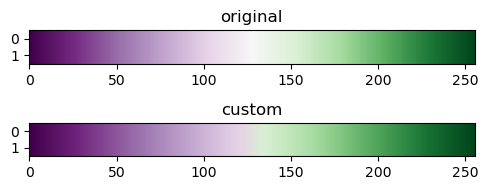

In [24]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,2))
ax1.imshow(gradient, cmap=orig_cmap, aspect='auto')
ax1.set_title('original')
ax2.imshow(gradient, cmap=cmap_new, aspect='auto')
ax2.set_title('custom')
plt.tight_layout()

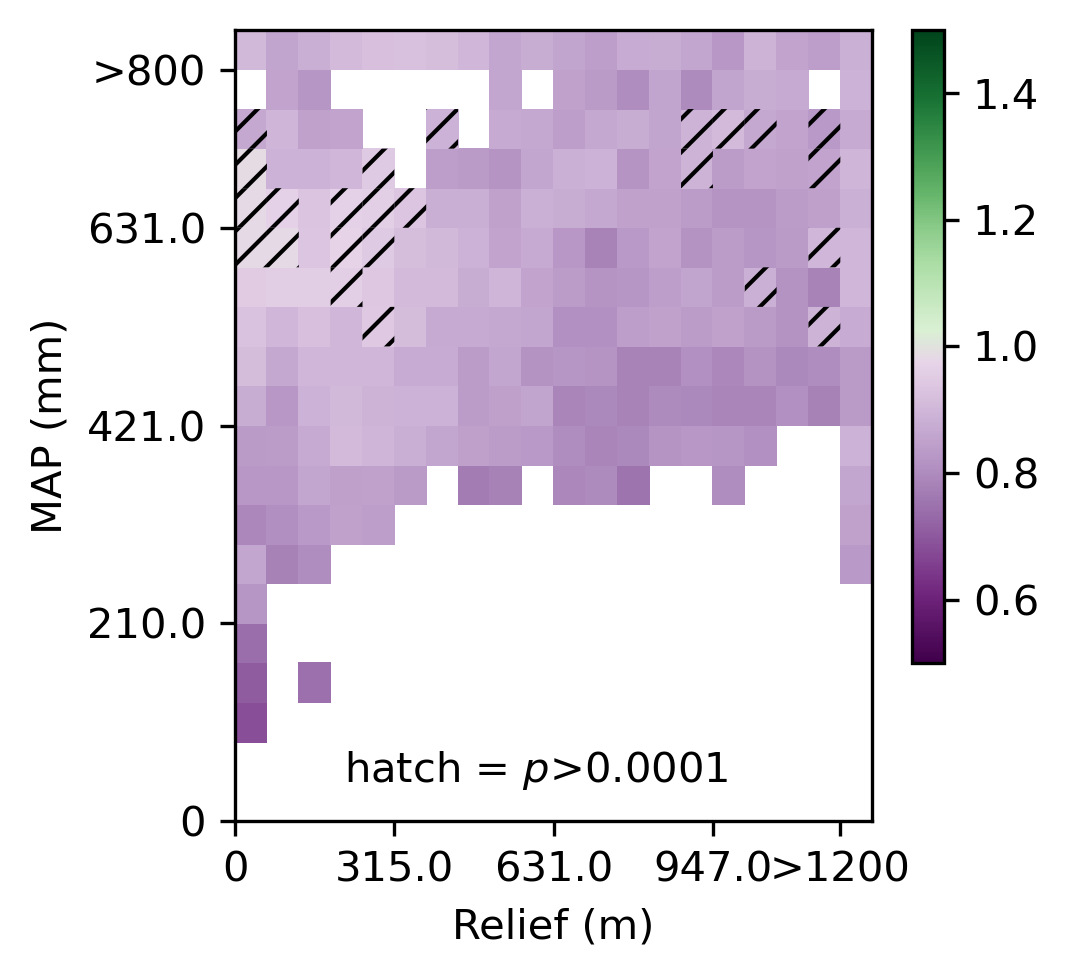

In [25]:
fig, ax = plt.subplots(figsize=(3.4252,3.4252),dpi=300)

im0 = ax.pcolor(ratio_masked,
               #   cmap='PRGn', 
                 cmap=cmap_new,
               #extent=[np.min(relief_array), np.max(relief_array), np.min(map_array), np.max(map_array)],
                vmin=0.5, vmax=1.5,
                   )

im1 = ax.pcolor(pm1_masked, hatch='///',alpha=0)

#im2 = ax.pcolor(pm2_masked, hatch='//',alpha=0)


cb1 = fig.colorbar(im0, shrink=0.8, anchor=(0.0, 1.0))
#ax.axvline(250)


ax.set_xticks([0,5,10,15,19])
ax.set_xticklabels(['0',np.round(relief_array[5],0),np.round(relief_array[10],0),np.round(relief_array[15],0),'>'+str(relief_max)])

ax.set_yticks([0,5,10,15,19])
ax.set_yticklabels(['0',np.round(map_array[5],0),np.round(map_array[10],0),np.round(map_array[15],0),'>'+str(map_max)])


ax.set_xlabel("Relief (m)")
ax.set_ylabel("MAP (mm)")
plt.annotate('hatch = $p$>0.0001', (3.4252,1))
#fig.suptitle("Ratio of drainage density of NH pf:nonpf soil-mantled headwater basins")
plt.savefig("./figure_outputs/main_heatmap_new.png", bbox_inches="tight")
plt.savefig("./figure_outputs/main_heatmap_new.pdf", bbox_inches="tight")

In [26]:
simplified_dict = {
    'Sporadic':'Patchy',
    'Isolated':'Patchy', 
    'Discontinuous':'Extensive',
    'Continuous':'Extensive',
    'No permafrost':'No permafrost'
}

joined_pf['simple'] = joined_pf['EXTENT'].map(simplified_dict)

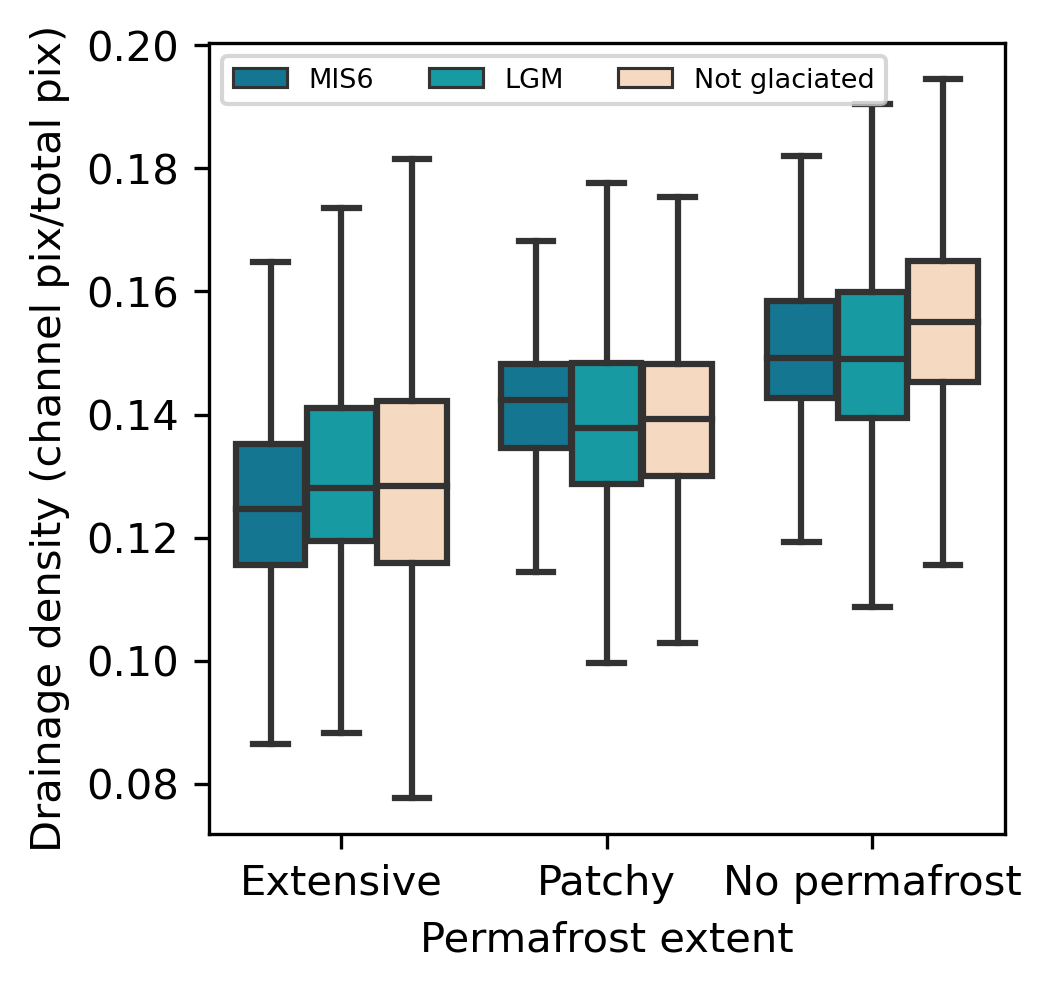

In [27]:
# from statannotations.Annotator import Annotator

x="simple"
y="DD"
hue="glaciated"
hue_order = ["MIS6","LGM","Not glaciated"]
order = ['Extensive','Patchy','No permafrost']
#pairs = [list(zip(hue_order, p)) for p in itertools.permutations(order)]
pairs=[
    # (("Extensive", "MIS6"), ("Patchy", "MIS6")),
    # (("Extensive", "MIS6"), ("No permafrost", "MIS6")),
    # (("Patchy", "MIS6"), ("No permafrost", "MIS6")),
    # (("Extensive", "Not glaciated"), ("Patchy", "Not glaciated")),
    # (("Extensive", "Not glaciated"), ("No permafrost", "Not glaciated")),
    # (("Patchy", "Not glaciated"), ("No permafrost", "Not glaciated")),
    ]

# filtered_data = joined_pf.loc[(joined_pf['bio12_mean'] < 700) & (joined_pf['ndvi_mean'] > 6000)]
filtered_data = joined_pf.loc[joined_pf['ndvi_mean'] > 6000]

fig, ax = plt.subplots(figsize=(3.4252,3.4252),dpi=300)
plot1 = sns.boxplot(data=filtered_data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
                 showfliers = False,
                palette=["#0081a7", "#00afb9", "#fed9b7"],
                ax=ax)

# for tick,label in zip(pos,ax.get_xticklabels()):
#     ax.text(pos[tick],
#             medians[tick],
#             nobs[tick],
#             horizontalalignment='center',
#             size='x-small',
#             color='k',
#             weight='semibold')

# annot = Annotator(plot1, pairs, data=filtered_data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
#                   showfliers = False,
#                  palette=["#0081a7", "#00afb9", "#fed9b7"],
#                  #ax=ax
#                  )
# annot.configure(test='Mann-Whitney', verbose=2)
# annot.apply_test()
# annot.annotate()
ax.set_ylabel("Drainage density (channel pix/total pix)")
ax.set_xlabel("Permafrost extent")
plt.legend(loc="upper left", ncol=3, fontsize=6.5)
plt.savefig("./figure_outputs/main_boxplots.png", bbox_inches="tight")
plt.savefig("./figure_outputs/main_boxplots.pdf", bbox_inches="tight")

In [28]:
# # from statannotations.Annotator import Annotator

# x="EXTENT"
# y="DD"
# hue="glaciated"
# hue_order = ["MIS6","LGM","Not glaciated"]
# order = ['Continuous','Discontinuous','Isolated','Sporadic','No permafrost']
# #pairs = [list(zip(hue_order, p)) for p in itertools.permutations(order)]
# pairs=[
#     (("Continuous", "Not glaciated"), ("Discontinuous", "Not glaciated")),
#     (("Continuous", "Not glaciated"), ("Isolated", "Not glaciated")),
#     (("Continuous", "Not glaciated"), ("No permafrost", "Not glaciated")),
#     (("Discontinuous", "Not glaciated"), ("No permafrost", "Not glaciated")),
#     (("Isolated", "Not glaciated"), ("No permafrost", "Not glaciated")),
#     (("Sporadic", "Not glaciated"), ("No permafrost", "Not glaciated")),
#     (("Discontinuous", "Not glaciated"), ("Sporadic", "Not glaciated")),
#     # (("Continuous", "Not glaciated"), ("Continuous", "LGM")),
#     # (("Continuous", "Not glaciated"), ("Continuous", "MIS6")),
#     # (("No permafrost", "Not glaciated"), ("No permafrost", "LGM")),
#     # (("No permafrost", "Not glaciated"), ("No permafrost", "MIS6")),
#     ]

# # filtered_data = joined_pf.loc[(joined_pf['bio12_mean'] < 700) & (joined_pf['ndvi_mean'] > 6000)]

# filtered_data = joined_pf.loc[joined_pf['ndvi_mean'] > 6000]

# fig, ax = plt.subplots(figsize=(6,3.4252),dpi=300)
# plot1 = sns.boxplot(data=filtered_data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
#                  showfliers = False,
#                 palette=["#0081a7", "#00afb9", "#fed9b7"],
#                 ax=ax)
# annot = Annotator(plot1, pairs, data=filtered_data, x=x, y=y, order=order, hue=hue, hue_order=hue_order,
#                   showfliers = False,
#                  palette=["#0081a7", "#00afb9", "#fed9b7"],
#                  #ax=ax
#                  )

# annot.configure(test='Mann-Whitney', verbose=2)
# annot.apply_test()
# annot.annotate()
# ax.tick_params(axis='x', rotation=45)
# ax.set_ylabel("Drainage density")
# plt.savefig('./figure_outputs/supp_pf_cat_expanded.png', bbox_inches="tight")

# Regression

In [29]:
permafrost['MAT_C'] = permafrost['bio01_mean']
nonpermafrost['MAT_C'] = nonpermafrost['bio01_mean']

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/neukom/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
# Just use non glaciated 
# Memory be damned

permafrost_ng= permafrost.loc[permafrost['glaciated'] == 'Not glaciated']
nonpermafrost_ng= nonpermafrost.loc[nonpermafrost['glaciated'] == 'Not glaciated']


#  

permafrost_ng = permafrost_ng.loc[permafrost_ng['MAT_C'] < 2.5]
nonpermafrost_ng = nonpermafrost_ng.loc[nonpermafrost_ng['MAT_C'] > -2.5]


In [31]:
import matplotlib as mpl

new_blues = mpl.cm.Blues(np.linspace(0,1,20))
new_blues = mpl.colors.ListedColormap(new_blues[5:,:-1])

new_reds = mpl.cm.Reds(np.linspace(0,1,20))
new_reds = mpl.colors.ListedColormap(new_reds[5:,:-1])

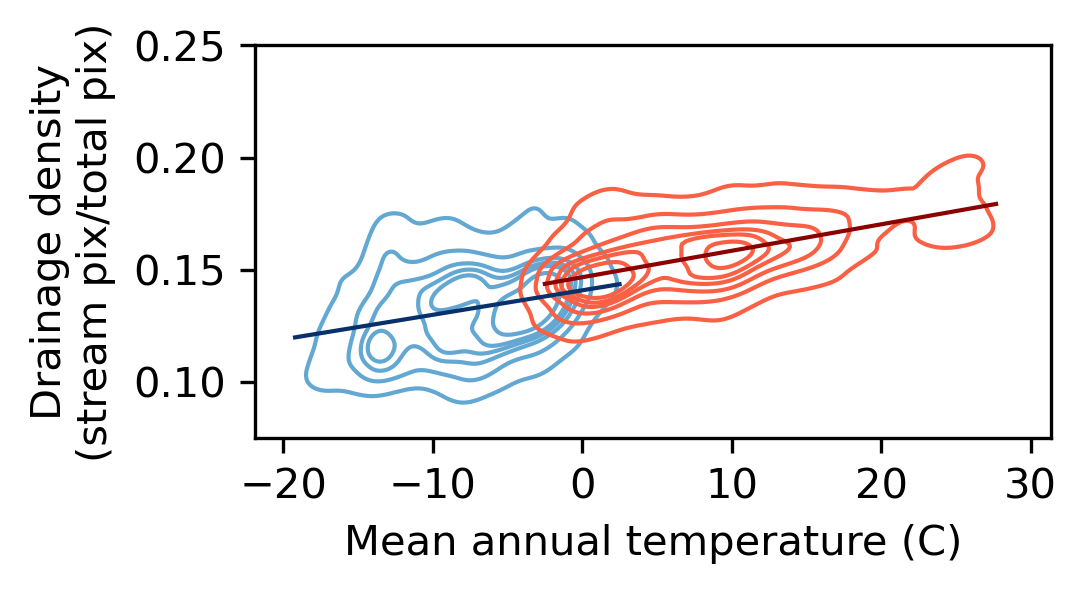

In [32]:
fig, ax = plt.subplots(
    # 1,2,
    # sharey=True,sharex=True,
     # figsize=(6,2),
    figsize=(3.4252,1.7),
                       dpi=300
                       )
ax.set_ylim((0.075,0.25))
# im0 = ax.hexbin(x=permafrost_ng['MAT_C'],
#                   y=permafrost_ng['DD'],
#                   mincnt=1,
#                   gridsize=(20,20),
#                  cmap=new_blues,
#                  )
im0=sns.kdeplot(
    data = permafrost_ng.drop(['level_0'], axis=1).reset_index(),
    x='MAT_C',
                  y='DD',
                  levels=7, 
                  linewidths=1,
                  color=mpl.cm.Blues(np.linspace(0,1,20))[-10],
                  ax=ax)

# im1 = sns.regplot(coolsheds['MAT_C'],
#                   coolsheds['DD'],
#                   scatter_kws={'alpha':0.05},
#                  ax=ax,
#                  ci=99,
#                  fit_reg=False,
#                  n_boot=1000,
#                   color='g'
#                  #robust=True,
#                  )
# im0 = ax.hexbin(x=nonpermafrost_ng['MAT_C'],
#                   y=nonpermafrost_ng['DD'],
#                   mincnt=1,
#                   gridsize=(26,20),
#                  cmap=new_reds,
#                  )
im0=sns.kdeplot(
    data = nonpermafrost_ng.drop(['level_0'], axis=1).reset_index(),
    x='MAT_C',
                  y='DD',
                  levels=7,
                  linewidths=1,
                  color=mpl.cm.Reds(np.linspace(0,1,20))[-10],
                  ax=ax)
im1 = sns.regplot(x=nonpermafrost_ng['MAT_C'],
                  y=nonpermafrost_ng['DD'],
                  scatter_kws={'alpha':0.00,
                              's':5},
                 line_kws={'color':'darkred',
                 'linewidth':1},
                 ax=ax,
                 ci=99,
                 fit_reg=True,
                 n_boot=1000,
                  color=mpl.cm.Reds(np.linspace(0,1,20))[-1],
                 #robust=True,
                 )
im05 = sns.regplot(x=permafrost_ng['MAT_C'],
                  y=permafrost_ng['DD'],
                  scatter_kws={'alpha':0.00,
                              's':5},
                  line_kws={'color':mpl.cm.Blues(np.linspace(0,1,20))[-1],
                  'linewidth':1},
                 ax=ax,
                 ci=99,
                 fit_reg=True,
                 n_boot=1000,
                  color='b',
                 #robust=True,
                 )

ax.set_ylabel("Drainage density\n(stream pix/total pix)")
ax.set_xlabel("Mean annual temperature (C)")
plt.savefig("./figure_outputs/main_mat_dd.pdf", bbox_inches="tight")


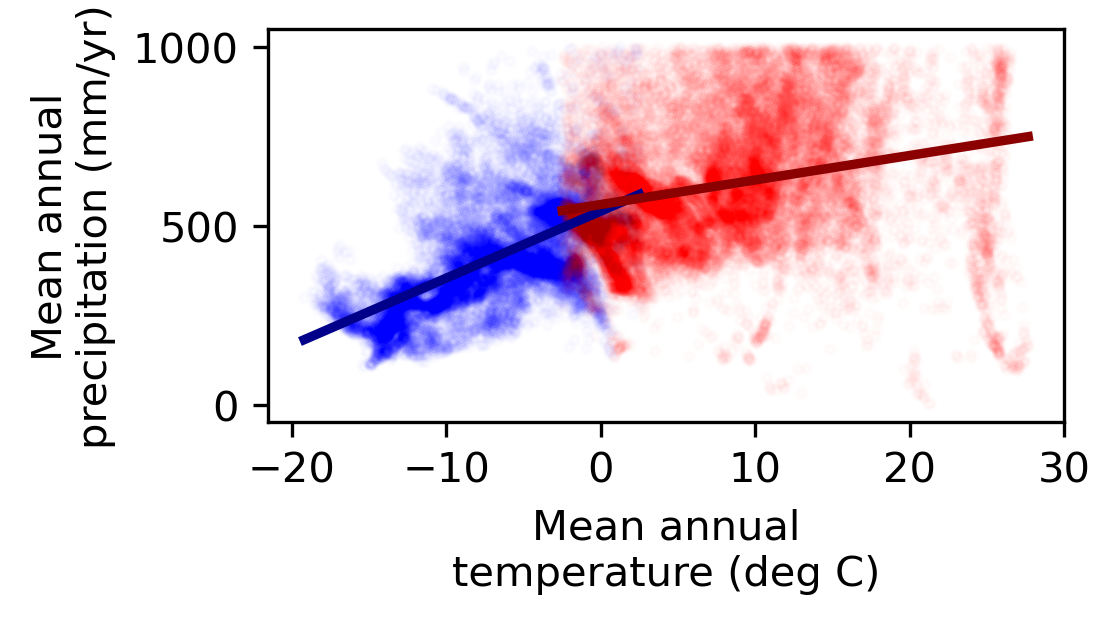

In [33]:
fig, ax = plt.subplots(figsize=(3.4252,1.7),
                       dpi=300)
im0 = sns.regplot(x=permafrost_ng['MAT_C'],
                  y=permafrost_ng['bio12_mean'],
                  scatter_kws={'alpha':0.01,
                              's':5},
                  line_kws={'color':'darkblue'},
                 ax=ax,
                 ci=99,
                 fit_reg=True,
                 n_boot=1000,
                  color='b'
                 #robust=True,
                 )

im1 = sns.regplot(x=nonpermafrost_ng['MAT_C'],
                  y=nonpermafrost_ng['bio12_mean'],
                  scatter_kws={'alpha':0.01,
                              's':5},
                 line_kws={'color':'darkred'},
                 ax=ax,
                 ci=99,
                 fit_reg=True,
                 n_boot=1000,
                  color='r'
                 #robust=True,
                 )
# ax.set_ylim((0.06,0.2))
ax.set_ylabel("Mean annual\nprecipitation (mm/yr)")
ax.set_xlabel("Mean annual\ntemperature (deg C)")

plt.savefig("./figure_outputs/supp_mat_map_regress.png", bbox_inches="tight")

In [34]:
import statsmodels.api as sm

X = permafrost_ng['MAT_C']  # independent variable
y = permafrost_ng['bio12_mean']  # dependent variable

# # to get intercept -- this is optional
# X = sm.add_constant(X)

# fit the regression model
reg = sm.OLS(y, X).fit()

permafrost_ng['residual_MAP'] = reg.resid

# Some nonpermafrost watersheds didn't have data, so we drop them

X = nonpermafrost_ng['MAT_C'].dropna()  # independent variable
y = nonpermafrost_ng['bio12_mean'].dropna()   # dependent variable

# # to get intercept -- this is optional
# X = sm.add_constant(X)

# fit the regression model
reg = sm.OLS(y, X).fit()

#nonpermafrost_ng['residual_MAP'] = nonpermafrost_ng.index.to_series().map(reg.resid)
# And now just add residuals to where we had data
nonpermafrost_ng['residual_MAP'] = pd.Series(
    nonpermafrost_ng.index,
     index=nonpermafrost_ng.index).map(reg.resid.to_dict())


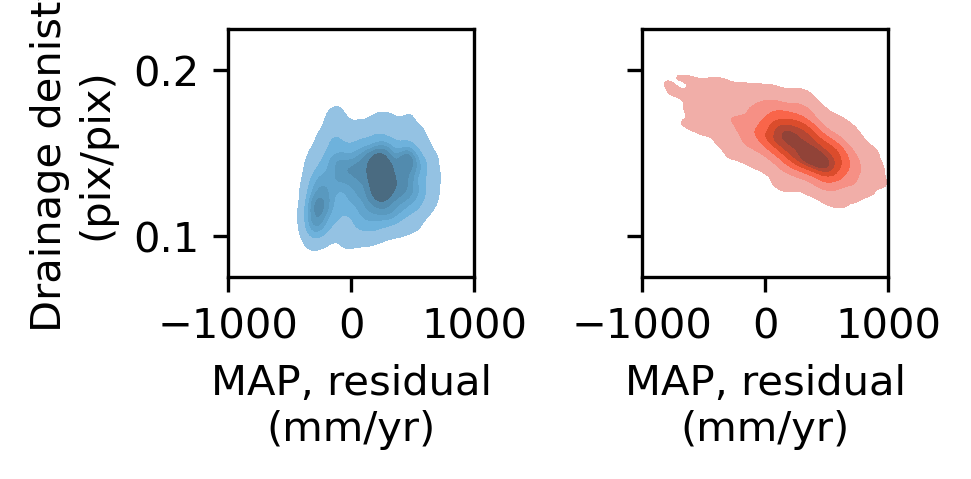

In [35]:
fig, ax = plt.subplots(1,2,
                       figsize=(3.4252,1.7),
                      #  figsize=(6,2),
                       sharey=True,
                       sharex=True,
                       dpi=300)
im0=sns.kdeplot(
    data = permafrost_ng.drop(['level_0'], axis=1).reset_index(),
    x='residual_MAP',
                  y='DD',
                  levels=7, 
                  # linewidths=1,
                 # palette=new_reds,
                  color=mpl.cm.Blues(np.linspace(0,1,20))[-10],
                  fill=True,
                  ax=ax[0])
# im0 = sns.regplot(x='residual_MAP', y='DD',  fit_reg=True,
#                   scatter_kws={'alpha':0.00,
#                               's':5},
#                   ax=ax[0], data=permafrost_ng,
#                                     line_kws={'color':'darkblue'},
#                  color='b')

# im1 = sns.regplot(x='residual_MAP', y='DD',  fit_reg=True,
#                   scatter_kws={'alpha':0.00,
#                               's':5},
#                   ax=ax[1], data=nonpermafrost_ng, color='r',
#                                   line_kws={'color':'darkred'})
im1=sns.kdeplot(
    data = nonpermafrost_ng.drop(['level_0'], axis=1).reset_index(),
    x='residual_MAP',
                  y='DD',
                  levels=7, 
                  # linewidths=1,
                  # palette=new_reds,
                  color=mpl.cm.Reds(np.linspace(0,1,20))[-10],
                  fill=True,
                  ax=ax[1])
ax[0].set_ylim((0.075, 0.225))
ax[0].set_xlim((-1000, 1000))
ax[0].set_ylabel("Drainage denisty\n(pix/pix)")

ax[0].set_xlabel("MAP, residual\n(mm/yr)")
ax[1].set_xlabel("MAP, residual\n(mm/yr)")


fig.tight_layout()

plt.savefig("./figure_outputs/main_resids.pdf", bbox_inches="tight")

# Supplemental

## Data maps

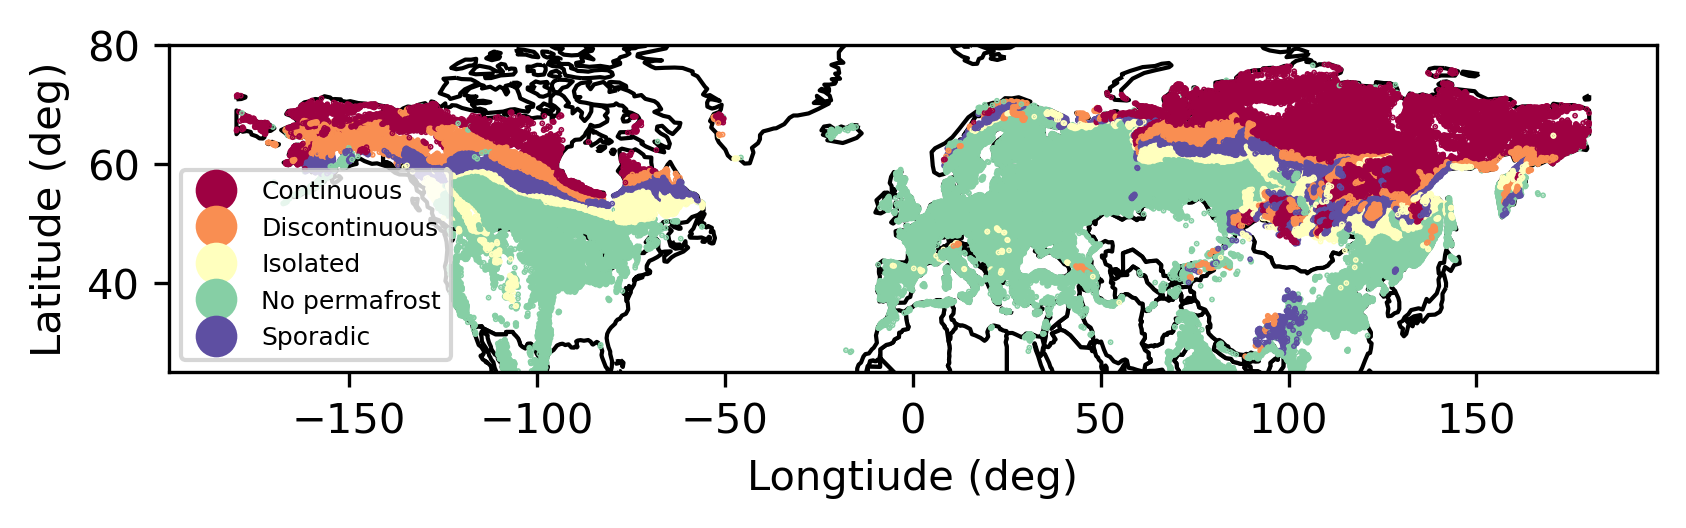

In [52]:
fig, ax = plt.subplots(dpi=300)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='white', edgecolor='black', ax=ax)

# We can now plot our ``GeoDataFrame``.
joined_pf.to_crs('EPSG:4326').plot(ax=ax, column="EXTENT", markersize=0.15,legend=True, cmap="Spectral", legend_kwds={'loc': 'lower left', 'fontsize':6})
ax.set_ylabel("Latitude (deg)")
ax.set_xlabel("Longtiude (deg)")
ax.set_ylim((25,80))
plt.savefig('./figure_outputs/supp_extent_map.png')

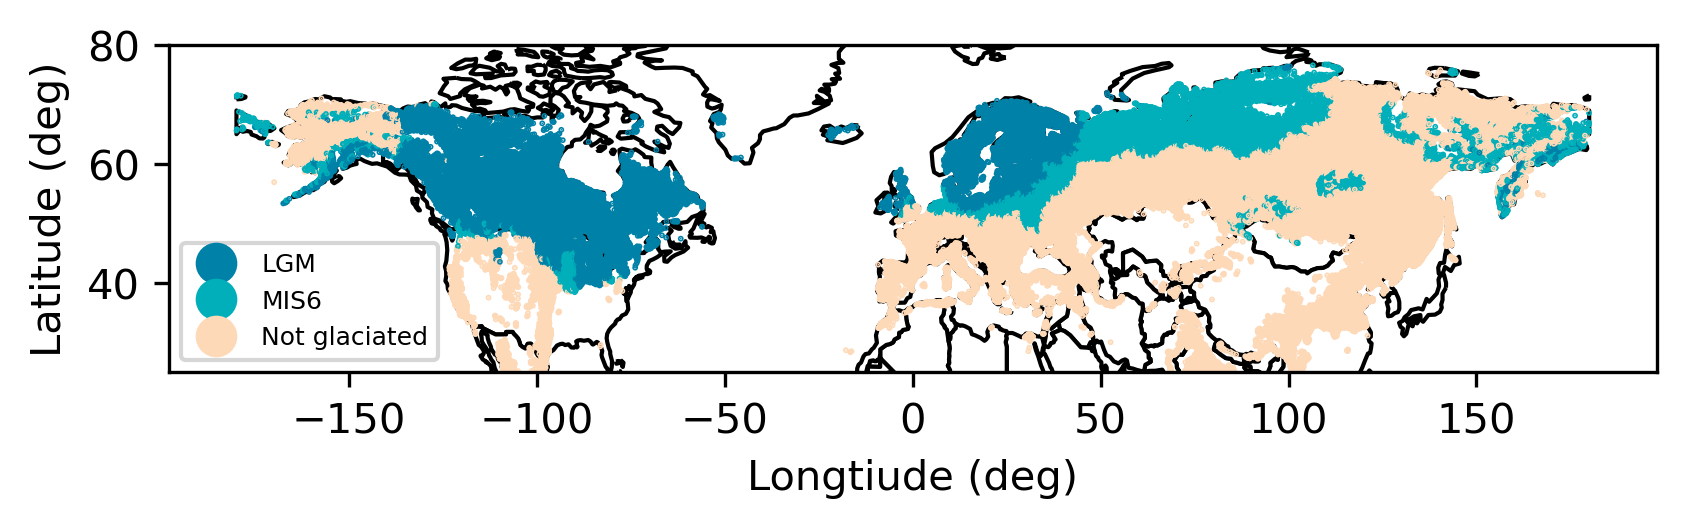

In [56]:
from  matplotlib.colors import ListedColormap

cols = ["#0081a7", "#00afb9", "#fed9b7"]

cmap = ListedColormap(cols)


fig, ax = plt.subplots(dpi=300)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='white', edgecolor='black', ax=ax)

# We can now plot our ``GeoDataFrame``.
joined_pf.to_crs('EPSG:4326').plot(ax=ax, column="glaciated", markersize=0.15,legend=True, cmap=cmap, legend_kwds={'loc': 'lower left', 'fontsize':6})
ax.set_ylim((25,80))
ax.set_ylabel("Latitude (deg)")
ax.set_xlabel("Longtiude (deg)")
ax.set_ylim((25,80))
plt.savefig('./figure_outputs/supp_glacial_map.png')

In [38]:
# Geopandas has not coded hexbins legends

# fig, ax = plt.subplots(dpi=300)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(
#     color='white', edgecolor='black', ax=ax)

# # We can now plot our ``GeoDataFrame``.
# im = joined_pf.to_crs('EPSG:4326').plot.hexbin(x='long',
#                                     y='lat',
#                                     C='DD',
#                                    legend=False,
#                                    vmin=0.1,
#                                    vmax=0.20,
#                                         # legend_kwds={
#                                         # # "location":"left",
#                                         # "shrink":.25,
#                                         # 'label':'Drainage density\n(pix/pix)'
#                                         #     },
#                                             ax=ax,
#                                             )


# ax.set_ylim((25,80))
# ax.set_ylabel("Latitude (deg)")
# ax.set_xlabel("Longtiude (deg)")
# ax.set_ylim((25,80))
# # plt.savefig('./figure_outputs/supp_DD_hex_map.png')

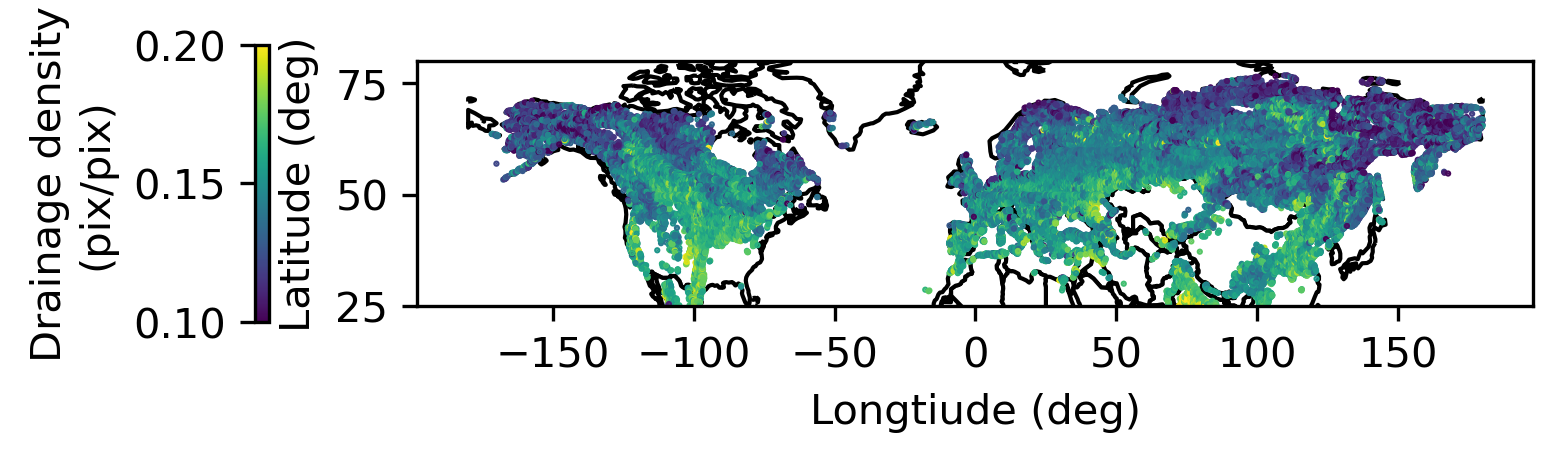

In [39]:
fig, ax = plt.subplots(dpi=300)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(
    color='white', edgecolor='black', ax=ax)

# We can now plot our ``GeoDataFrame``.
joined_pf.to_crs('EPSG:4326').plot(ax=ax, column="DD", markersize=0.25,legend=True,
                                   vmin=0.1,
                                   vmax=0.20,
                                        legend_kwds={
                                        "location":"left",
                                        "shrink":.25,
                                        'label':'Drainage density\n(pix/pix)'
                                            },
                                            )
ax.set_ylim((25,80))
ax.set_ylabel("Latitude (deg)")
ax.set_xlabel("Longtiude (deg)")
ax.set_ylim((25,80))
plt.savefig('./figure_outputs/supp_DD_map.png')

## Data stats

In [40]:
joined_pf.groupby(['EXTENT', 'glaciated']).size()
# joined_pf['EXTENT'].value_counts()

EXTENT         glaciated    
Continuous     LGM               2004
               MIS6              4549
               Not glaciated     7923
Discontinuous  LGM               1911
               MIS6              1321
               Not glaciated     2772
Isolated       LGM               2177
               MIS6               338
               Not glaciated     3204
No permafrost  LGM              10645
               MIS6              3755
               Not glaciated    23220
Sporadic       LGM               2784
               MIS6               977
               Not glaciated     2104
dtype: int64

In [41]:
joined_pf['EXTENT'].value_counts()

No permafrost    37620
Continuous       14476
Discontinuous     6004
Sporadic          5865
Isolated          5719
Name: EXTENT, dtype: int64

In [42]:
joined_pf['glaciated'].value_counts()

Not glaciated    39223
LGM              19521
MIS6             10940
Name: glaciated, dtype: int64

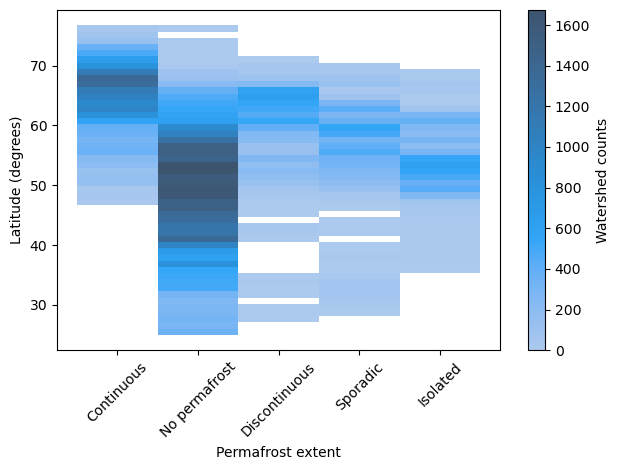

In [43]:
fig, ax = plt.subplots()
sns.histplot(data=joined_pf, y='lat', x='EXTENT',
            #  hue='glaciated',
             bins=50,
            #  thresh=10,
             cbar=True,
             cbar_kws={"label":"Watershed counts"},
             ax=ax)
# sns.violinplot(data=joined_pf, x='lat', y='EXTENT', 
#              order=['No permafrost', 'Isolated', 'Sporadic','Discontinuous', 'Continuous'],
#              inner=None,            
#              )
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel("Latitude (degrees)")
ax.set_xlabel("Permafrost extent")
fig.tight_layout()
plt.savefig('./figure_outputs/supp_lat_cat.png')

In [44]:
for_export = joined_pf.filter(['long', 'lat', 'HYBAS_ID',  'segment', 'flow_acc', 'relief', 'bio12_mean', 'bio01_mean', 'ndvi_mean', 'glaciated', 'EXTENT','DD']).dropna()

In [45]:
for_export

,long,lat,HYBAS_ID,segment,flow_acc,relief,bio12_mean,bio01_mean,ndvi_mean,glaciated,EXTENT,DD
16,179.956161,68.531219,3100011920,5956,41664,175.458649,274.980806,-12.134467,6386.139157,MIS6,Continuous,0.142953
25,179.954777,66.584006,3100012060,31555,294091,933.151711,350.600216,-12.276970,6450.000000,MIS6,Continuous,0.107297
36423,162.750024,69.275043,3100762760,66348,637672,658.998581,172.187951,-15.243313,6357.825527,MIS6,Continuous,0.104047
36493,162.890665,69.106827,3100118850,118135,1106825,679.224091,181.822962,-15.454740,6292.213884,Not glaciated,Continuous,0.106733
36598,163.780149,67.025739,3100177640,144051,1056249,434.326752,212.167980,-12.613258,7599.951700,Not glaciated,Continuous,0.136380
...,...,...,...,...,...,...,...,...,...,...,...,...
95193,164.140252,58.957999,3100456760,32725,214735,727.000000,537.873641,-2.883543,8224.528571,Not glaciated,Discontinuous,0.152397
95194,164.350323,58.929696,3100023930,27064,218013,768.000000,541.352894,-2.941786,8192.647991,Not glaciated,Discontinuous,0.124139
95195,164.576658,58.959509,3100023920,75089,617478,520.000000,531.254517,-2.679216,8343.115647,Not glaciated,Discontinuous,0.121606
95201,166.426226,54.880150,3100024180,79516,741209,608.000000,749.707734,1.722580,6435.826077,Not glaciated,No permafrost,0.107279


In [46]:
for_export.to_csv("watershed_export.csv")

In [47]:
for_export[(for_export['EXTENT'] == 'No permafrost') & (for_export['glaciated'] == 'Not glaciated')]

,long,lat,HYBAS_ID,segment,flow_acc,relief,bio12_mean,bio01_mean,ndvi_mean,glaciated,EXTENT,DD
340,-166.392612,64.838067,8100006180,294,1791,13.804371,416.019022,-4.100000,6554.000000,Not glaciated,No permafrost,0.164154
342,-166.702341,65.367550,8100006260,15424,114375,241.213919,398.173399,-4.889539,6454.590417,Not glaciated,No permafrost,0.134855
599,-163.493301,60.753318,8100276640,13485,107849,8.715471,559.321559,-1.007411,6639.820667,Not glaciated,No permafrost,0.125036
630,-163.634500,63.128400,8100005540,9780,92109,1.997152,461.151705,-2.478415,7545.211902,Not glaciated,No permafrost,0.106179
892,-161.904748,65.985496,8100006780,5430,45085,90.726220,310.877227,-5.035321,6891.894234,Not glaciated,No permafrost,0.120439
...,...,...,...,...,...,...,...,...,...,...,...,...
95156,162.349242,56.443867,3100014940,34845,231835,460.000000,686.613630,-0.922174,8982.193053,Not glaciated,No permafrost,0.150301
95157,162.478995,56.290599,3100014960,26756,196761,5.000000,692.377340,-0.465928,8468.581909,Not glaciated,No permafrost,0.135982
95167,163.056481,57.794818,3100014580,65613,500526,635.000000,620.669009,-2.371409,8443.065586,Not glaciated,No permafrost,0.131088
95201,166.426226,54.880150,3100024180,79516,741209,608.000000,749.707734,1.722580,6435.826077,Not glaciated,No permafrost,0.107279


## dumb stuff

Sangireddy et al 2016 has a discussion on relief and DD and whether the relationship would be positive or negative depending on if you were in creep or landslide dominated stuff at higher reliefs: "Geomorphic transport laws used in landscape evolution models predict a power-law relationship between Dd and R (D / Rn) such that the correlation between the variables is positive in creep dominated landscapes and negative in landslide prone ones (Tucker and Bras, 1998)"

(0.05, 0.2)

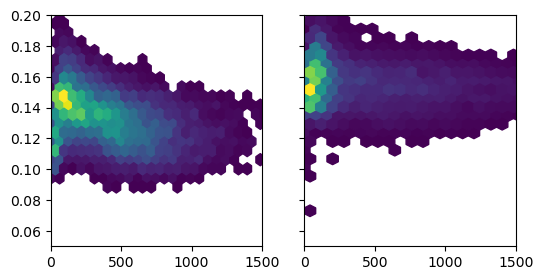

In [48]:
fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
ax[0].hexbin(permafrost_ng['relief'],permafrost_ng['DD'], 
             gridsize=(75,20), 
             mincnt=5)
ax[1].hexbin(nonpermafrost_ng['relief'],nonpermafrost_ng['DD'],
             gridsize=(75,20), 
                mincnt=5)
ax[0].set_xlim(0,1500)
ax[0].set_ylim(0.05,0.20)

(0.05, 0.2)

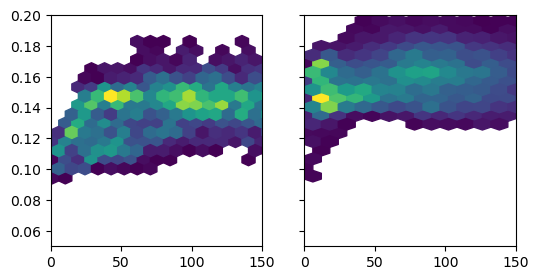

In [49]:
fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
ax[0].hexbin(permafrost_ng['relief'],permafrost_ng['DD'], gridsize=(500,20), mincnt=5)
ax[1].hexbin(nonpermafrost_ng['relief'],nonpermafrost_ng['DD'], gridsize=(500,20), mincnt=5)
ax[0].set_xlim(0,150)
ax[0].set_ylim(0.05,0.20)

enjoy this easter egg that might be a future paper or something